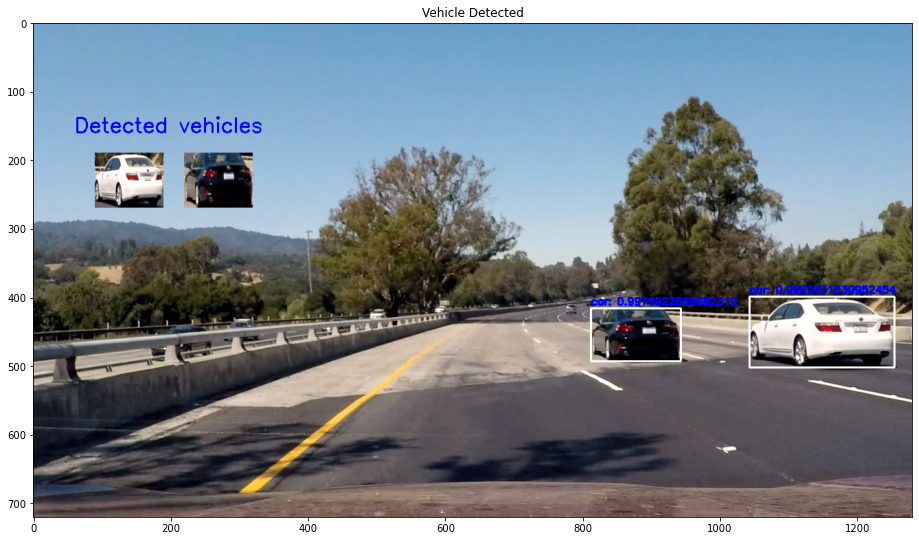

In [7]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
weights_path ="D:/Phase2/trial2/yolov3.weights"
config_path ="D:/Phase2/trial2/yolov3.cfg"
labels_path ="D:/Phase2/trial2/coco.names"



net = cv2.dnn.readNetFromDarknet(config_path, weights_path)
layers_names = ['yolo_82', 'yolo_94', 'yolo_106']

labels = open(labels_path).read().strip().split("\n")


Frame_Flag = True
iou_threshold = 0.5
Filtered_boxes = []
Filtered_confidence = []
Filtered_classIDs = []


def iou(box1, box2):
    tb = min(box1[0]+0.5*box1[2], box2[0]+0.5*box2[2])-max(box1[0]-0.5*box1[2], box2[0]-0.5*box2[2])
    lr = min(box1[1]+0.5*box1[3], box2[1]+0.5*box2[3])-max(box1[1]-0.5*box1[3], box2[1]-0.5*box2[3])
    if tb < 0 or lr < 0:
        intersection = 0
    else:
        intersection = tb*lr
    return intersection / (box1[2]*box1[3] + box2[2]*box2[3] - intersection)


def draw(img_cp, img, window_list, thumb_w=100, thumb_h=80, off_x=30, off_y=160):

        cv2.putText(img_cp, 'Detected vehicles', (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), thickness=2)
        for i, bbox in enumerate(window_list):
            try:
                (x, y) = [bbox[0], bbox[1]]
                (w, h) = [bbox[2], bbox[3]]
                if x < 0:
                    x = 0
                if y < 0:
                    y = 0
                thumbnail = img[y:(y+h), x:(x+w)]
                vehicle_thumb = cv2.resize(thumbnail, dsize=(thumb_w, thumb_h))
                start_x = 60 + (i+1) * off_x + i * thumb_w
                img_cp[off_y + 30:off_y + thumb_h + 30, start_x:start_x + thumb_w, :] = vehicle_thumb
            except:
                continue

def draw_labeled_bboxes(img, Filtered_boxes, Filtered_confidence, Filtered_classIDs):
    img_cp = img.copy()
    for i in range(len(Filtered_boxes)):
        (x, y) = [Filtered_boxes[i][0], Filtered_boxes[i][1]]
        (w, h) = [Filtered_boxes[i][2], Filtered_boxes[i][3]]
        cv2.rectangle(img_cp, (x, y), (x + w, y + h), (255, 255, 255), thickness=2)
        cv2.putText(img_cp, "{}: {}".format(labels[Filtered_classIDs[i]], Filtered_confidence[i]), (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (0, 0, 255), thickness=2)
    draw(img_cp, img, Filtered_boxes)
    return img_cp


def Process(img):
    global net, layers_names, labels, Frame_Flag, Filtered_boxes, Filtered_confidence, Filtered_classIDs, iou_threshold
    if Frame_Flag:
        boxes = []
        confidences = []
        classIDs = []

        (H, W) = img.shape[:2]
        blob = cv2.dnn.blobFromImage(img, 1 / 255.0, (416, 416), crop=False, swapRB=False)
        net.setInput(blob)

        layers_output = net.forward(layers_names)

        for output in layers_output:
            for detection in output:
                scores = detection[5:]
                classID = np.argmax(scores)
                confidence = scores[classID]
                if (confidence > 0.85):
                    box = detection[:4] * np.array([W, H, W, H])
                    bx, by, bw, bh = box.astype("int")
                    x = int(bx - (bw / 2))
                    y = int(by - (bh / 2))
                    boxes.append([x, y, int(bw), int(bh)])
                    confidences.append(float(confidence))
                    classIDs.append(classID)

        idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.8, 0.8)

        Filtered_boxes = []
        Filtered_confidence = []
        Filtered_classIDs = []

        for i in idxs:
            flag = True
            for j in idxs:
                if (i == j):
                    continue
                if (iou(boxes[i], boxes[j]) > iou_threshold):
                    if (confidences[i] < confidences[j]):
                        flag = False
            if flag:
                Filtered_boxes.append(boxes[i])
                Filtered_confidence.append(confidences[i])
                Filtered_classIDs.append(classIDs[i])

    draw_img = draw_labeled_bboxes(img, Filtered_boxes, Filtered_confidence, Filtered_classIDs)
    Frame_Flag = not Frame_Flag
    return draw_img
def drawimg(img):

    out = Process(img)

    plt.figure(figsize=(40, 20))
    plt.subplot(222)
    plt.imshow(out)
    plt.title('Vehicle Detected')
    
    return

img = cv2.imread("C:/Phase2/Lane Detection/test_images/test4.jpg")
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
drawimg(img)